## Install libraries

In [ ]:
!pip install -q datasets[audio]
!pip install -q 'torchaudio<0.12.0'

In [ ]:
!pip install -q transformers

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
model_checkpoint = "facebook/wav2vec2-base"
batch_size = 5
num_classes = 10
class_names = ['Tylenol', 'Advil', 'Bayer', 'Aleve', 'Panadol', 'Voltaren', 'Ponstel', 'Dolo', 'Indocin', 'Pyridium']
max_duration = 20.0 # not seconds actually

## Load dataset

In [ ]:
from datasets import load_dataset
from datasets import load_metric

In [ ]:
metric = load_metric("accuracy")
dataset = load_dataset("audiofolder", data_dir="/content/drive/MyDrive/Dataset/fyp_dataset_final", split="train")

Resolving data files:   0%|          | 0/901 [00:00<?, ?it/s]

In [ ]:
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 900
})

In [ ]:
dataset.features

{'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'label': Value(dtype='string', id=None)}

In [ ]:
from datasets import ClassLabel
medicine_classlabel = ClassLabel(num_classes = num_classes,names = class_names)
dataset = dataset.cast_column("label", medicine_classlabel)

In [ ]:
dataset['label'][0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 720
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 180
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['audio', 'label'],
    num_rows: 720
})

In [ ]:
dataset['train'][0]

{'audio': {'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Indocin_73.wav',
  'array': array([-0.00042725, -0.00048828, -0.00064087, ..., -0.00042725,
         -0.0005188 , -0.00061035]),
  'sampling_rate': 22050},
 'label': 8}

In [ ]:
label2id, id2label = dict(), dict()
for i, label in enumerate(class_names):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label["9"]

'Pyridium'

Listen to sample audios

In [ ]:
import random
from IPython.display import Audio, display

for _ in range(5):
    rand_idx = random.randint(0, len(dataset["train"])-1)
    example = dataset["train"][rand_idx]
    audio = example["audio"]

    print(f'Label: {example["label"]}')
    print(f'Shape: {audio["array"].shape}, sampling rate: {audio["sampling_rate"]}')
    display(Audio(audio["array"], rate=audio["sampling_rate"]))
    print()

Label: 3
Shape: (15435,), sampling rate: 22050



Label: 0
Shape: (28665,), sampling rate: 22050



Label: 3
Shape: (24255,), sampling rate: 22050



Label: 8
Shape: (26460,), sampling rate: 22050



Label: 3
Shape: (22050,), sampling rate: 22050


In [ ]:
dataset["test"][5]["audio"]

{'path': '/content/drive/MyDrive/Dataset/fyp_dataset_final/train/Pyridium_2.wav',
 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.52587891e-05,  1.52587891e-05]),
 'sampling_rate': 44100}

## Preprocess the data

In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.9/dist-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

In [ ]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        # max_length=int(feature_extractor.sampling_rate * max_duration), 
        # truncation=True, 
    )
    return inputs

In [ ]:
encoded_dataset = dataset.map(preprocess_function, remove_columns=["audio"], batched=True)
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_values'],
        num_rows: 720
    })
    test: Dataset({
        features: ['label', 'input_values'],
        num_rows: 180
    })
})

## Training the model

In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer

model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint, 
    num_labels=num_classes,
    label2id=label2id,
    id2label=id2label,
)

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_hid.bias', 'project_q.weight', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.weight', 'projector.bias', 'classifier

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-mednames",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

/content/wav2vec2-base-finetuned-mednames is already a clone of https://huggingface.co/santhosh-4000/wav2vec2-base-finetuned-mednames. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.278900,2.263930,0.222222
2,2.192500,2.140448,0.383333
3,1.876300,1.760662,0.555556
4,1.503500,1.359893,0.766667
5,1.059800,0.960663,0.877778
6,0.830300,0.732677,0.872222
7,0.641800,0.554422,0.877778
8,0.448100,0.437669,0.972222
9,0.343800,0.296252,0.983333
10,0.183100,0.144250,1.000000


Epoch,Training Loss,Validation Loss,Accuracy
1,2.278900,2.263930,0.222222
2,2.192500,2.140448,0.383333
3,1.876300,1.760662,0.555556
4,1.503500,1.359893,0.766667
5,1.059800,0.960663,0.877778
6,0.830300,0.732677,0.872222
7,0.641800,0.554422,0.877778
8,0.448100,0.437669,0.972222
9,0.343800,0.296252,0.983333
10,0.183100,0.144250,1.000000


TrainOutput(global_step=1080, training_loss=0.43183010043231423, metrics={'train_runtime': 2909.1982, 'train_samples_per_second': 7.425, 'train_steps_per_second': 0.371, 'total_flos': 5.7550747163293466e+17, 'train_loss': 0.43183010043231423, 'epoch': 30.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14425045251846313,
 'eval_accuracy': 1.0,
 'eval_runtime': 4.5387,
 'eval_samples_per_second': 39.659,
 'eval_steps_per_second': 7.932,
 'epoch': 30.0}

In [ ]:
predictions = np.argmax(trainer.predict(encoded_dataset["test"]).predictions, axis=1)
actual_labels = [id2label[str(x)] for x in dataset['test']['label']]
prediction_labels = [id2label[str(x)] for x in predictions]
transcriptions = prediction_labels

In [ ]:
# print('predictions:', prediction_labels)
# print('actual:', actual_labels)

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
stopwords = set(STOPWORDS)
prediction_str = ''

prediction_str += " ".join(transcriptions)+" "
prediction_str

'Bayer Dolo Tylenol Indocin Tylenol Pyridium Dolo Bayer Bayer Ponstel Pyridium Aleve Indocin Tylenol Tylenol Voltaren Tylenol Ponstel Ponstel Bayer Voltaren Pyridium Pyridium Voltaren Tylenol Indocin Panadol Voltaren Voltaren Voltaren Panadol Aleve Indocin Tylenol Ponstel Aleve Panadol Voltaren Pyridium Dolo Dolo Tylenol Aleve Aleve Dolo Pyridium Bayer Advil Ponstel Advil Bayer Advil Ponstel Pyridium Bayer Indocin Panadol Panadol Aleve Advil Bayer Ponstel Panadol Aleve Bayer Panadol Panadol Aleve Tylenol Pyridium Tylenol Aleve Tylenol Dolo Aleve Indocin Panadol Tylenol Indocin Voltaren Advil Aleve Aleve Voltaren Dolo Pyridium Bayer Voltaren Pyridium Panadol Tylenol Indocin Tylenol Bayer Indocin Tylenol Voltaren Ponstel Ponstel Dolo Dolo Ponstel Bayer Indocin Pyridium Ponstel Dolo Tylenol Voltaren Ponstel Dolo Dolo Dolo Advil Bayer Dolo Bayer Voltaren Indocin Tylenol Ponstel Panadol Voltaren Indocin Bayer Pyridium Pyridium Advil Advil Indocin Indocin Aleve Bayer Voltaren Panadol Pyridiu

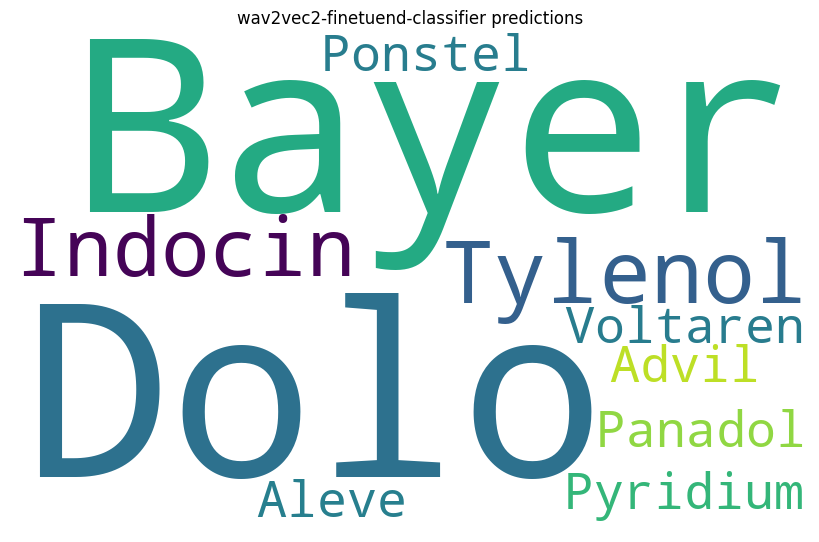

In [ ]:
wordcloud = WordCloud(width = 800, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(prediction_str)

plt.figure(figsize = (8, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('wav2vec2-finetuend-classifier predictions')
plt.show()

## upload best model to hub

In [ ]:
trainer.push_to_hub()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr19_09-12-19_11ec4160ba19/events.out.tfevents.1681895546.11ec4160ba19.151.9:   0%|         …

Upload file runs/Apr19_09-12-19_11ec4160ba19/events.out.tfevents.1681898460.11ec4160ba19.151.11:   0%|        …

To https://huggingface.co/santhosh-4000/wav2vec2-base-finetuned-mednames
   9201ef8..d6b0aa2  main -> main

   9201ef8..d6b0aa2  main -> main

To https://huggingface.co/santhosh-4000/wav2vec2-base-finetuned-mednames
   d6b0aa2..5d5f486  main -> main

   d6b0aa2..5d5f486  main -> main



'https://huggingface.co/santhosh-4000/wav2vec2-base-finetuned-mednames/commit/d6b0aa204923cccc674ae012821b2ce62d07f249'

## getting inference

In [ ]:
# # For managing audio file
# import librosa

# audio, rate = librosa.load("/content/drive/MyDrive/Dataset/fyp_dataset_50_mp3/train/Aleve_1.mp3", sr = 16000)

In [ ]:
# audio

In [ ]:
# from transformers import pipeline
# def pipeline_predict(input):
#   classifier = pipeline("audio-classification", model="santhosh-4000/wav2vec2-base-finetuned-mednames")
#   return classifier(input)

In [ ]:
# pipeline_predict(audio)

In [ ]:
# dataset['train'][:10]

In [ ]:
# transcriptions = []
# for input_values in dataset['train']['audio'][:10]:
#   transcription = pipeline_predict(input_values['array'])
#   transcriptions.append(transcription)

In [ ]:
# transcriptions

In [ ]:
# transcription_ids = [label2id[str(x[0]['label'])] for x in transcriptions]
# metric.compute(predictions=transcription_ids, references=dataset['train']['label'][:10])

## cer metric

In [ ]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
!pip install -q jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00


In [ ]:
from evaluate import load
cer = load("cer")
cer_score = cer.compute(predictions=prediction_labels, references=actual_labels)

In [ ]:
print(cer_score)

0.0


In [ ]:
prediction_labels

['Bayer',
 'Dolo',
 'Tylenol',
 'Indocin',
 'Tylenol',
 'Pyridium',
 'Dolo',
 'Bayer',
 'Bayer',
 'Ponstel',
 'Pyridium',
 'Aleve',
 'Indocin',
 'Tylenol',
 'Tylenol',
 'Voltaren',
 'Tylenol',
 'Ponstel',
 'Ponstel',
 'Bayer',
 'Voltaren',
 'Pyridium',
 'Pyridium',
 'Voltaren',
 'Tylenol',
 'Indocin',
 'Panadol',
 'Voltaren',
 'Voltaren',
 'Voltaren',
 'Panadol',
 'Aleve',
 'Indocin',
 'Tylenol',
 'Ponstel',
 'Aleve',
 'Panadol',
 'Voltaren',
 'Pyridium',
 'Dolo',
 'Dolo',
 'Tylenol',
 'Aleve',
 'Aleve',
 'Dolo',
 'Pyridium',
 'Bayer',
 'Advil',
 'Ponstel',
 'Advil',
 'Bayer',
 'Advil',
 'Ponstel',
 'Pyridium',
 'Bayer',
 'Indocin',
 'Panadol',
 'Panadol',
 'Aleve',
 'Advil',
 'Bayer',
 'Ponstel',
 'Panadol',
 'Aleve',
 'Bayer',
 'Panadol',
 'Panadol',
 'Aleve',
 'Tylenol',
 'Pyridium',
 'Tylenol',
 'Aleve',
 'Tylenol',
 'Dolo',
 'Aleve',
 'Indocin',
 'Panadol',
 'Tylenol',
 'Indocin',
 'Voltaren',
 'Advil',
 'Aleve',
 'Aleve',
 'Voltaren',
 'Dolo',
 'Pyridium',
 'Bayer',
 'Voltaren',


In [ ]:
actual_labels

['Bayer',
 'Dolo',
 'Tylenol',
 'Indocin',
 'Tylenol',
 'Pyridium',
 'Dolo',
 'Bayer',
 'Bayer',
 'Ponstel',
 'Pyridium',
 'Aleve',
 'Indocin',
 'Tylenol',
 'Tylenol',
 'Voltaren',
 'Tylenol',
 'Ponstel',
 'Ponstel',
 'Bayer',
 'Voltaren',
 'Pyridium',
 'Pyridium',
 'Voltaren',
 'Tylenol',
 'Indocin',
 'Panadol',
 'Voltaren',
 'Voltaren',
 'Voltaren',
 'Panadol',
 'Aleve',
 'Indocin',
 'Tylenol',
 'Ponstel',
 'Aleve',
 'Panadol',
 'Voltaren',
 'Pyridium',
 'Dolo',
 'Dolo',
 'Tylenol',
 'Aleve',
 'Aleve',
 'Dolo',
 'Pyridium',
 'Bayer',
 'Advil',
 'Ponstel',
 'Advil',
 'Bayer',
 'Advil',
 'Ponstel',
 'Pyridium',
 'Bayer',
 'Indocin',
 'Panadol',
 'Panadol',
 'Aleve',
 'Advil',
 'Bayer',
 'Ponstel',
 'Panadol',
 'Aleve',
 'Bayer',
 'Panadol',
 'Panadol',
 'Aleve',
 'Tylenol',
 'Pyridium',
 'Tylenol',
 'Aleve',
 'Tylenol',
 'Dolo',
 'Aleve',
 'Indocin',
 'Panadol',
 'Tylenol',
 'Indocin',
 'Voltaren',
 'Advil',
 'Aleve',
 'Aleve',
 'Voltaren',
 'Dolo',
 'Pyridium',
 'Bayer',
 'Voltaren',
